In [1]:
import os
import gc
import torch
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ['CUDA_LAUNCH_BLOCKING'] = '0'


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset

# Score-Based Diffusion Model on Fashion-MNIST

## Comprehensive Comparison: DDPM vs Score-Based Diffusion

This notebook implements **Score-Based Diffusion** (also known as **VE-SDE** - Variance Exploding Stochastic Differential Equation) and compares it with **DDPM** (Denoising Diffusion Probabilistic Models).

### Quick Overview

| Aspect | DDPM (VP-SDE)| Score-Based (VE-SDE) |
|--------|------|----------------------|
| **Core Concept** | Reverse a fixed Markov chain | Learn score function ∇log p(x) |
| **Noise Schedule** | Discrete timesteps (β schedule) | Continuous noise levels (σ schedule) |
| **Training** | Predict noise ε | Predict score ∇log p(x\|σ) |
| **Loss** | MSE on noise | Weighted MSE on score |
| **Sampling** | Reverse DDPM steps | Annealed Langevin Dynamics / EDM |

In [3]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, classification_report
from scipy.linalg import sqrtm
from tqdm import tqdm
import copy
import os

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## Step 1: Load Fashion-MNIST Dataset
### I selected 30,000 samples of the training set for faster training

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

np.random.seed(42)
indices = np.random.choice(len(train_dataset), size=30000, replace=False)
train_subset = Subset(train_dataset, indices)

batch_size = 256
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

train_data = train_dataset.data[indices].float() / 255.0 * 2.0 - 1.0
train_labels = train_dataset.targets[indices]

test_data = test_dataset.data.float() / 255.0 * 2.0 - 1.0
print(f"Training set size: {len(train_subset)}")
print(f"Test set size: {len(test_dataset)}")
print(f"Image shape: {train_dataset[0][0].shape}")
print(f"Data range: [{train_dataset[0][0].min():.3f}, {train_dataset[0][0].max():.3f}]")

Training set size: 30000
Test set size: 10000
Image shape: torch.Size([1, 28, 28])
Data range: [-1.000, 1.000]


## Step 2: Build Score Network

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class SelfAttention(nn.Module):
    """Multi-head self-attention module"""
    def __init__(self, channels, size):
        super(SelfAttention, self).__init__()
        self.channels = channels
        self.size = size
        self.mha = nn.MultiheadAttention(channels, 4, batch_first=True)
        self.ln = nn.LayerNorm([channels])
        self.ff_self = nn.Sequential(
            nn.LayerNorm([channels]),
            nn.Linear(channels, channels),
            nn.GELU(),
            nn.Linear(channels, channels),
        )

    def forward(self, x):
        x = x.view(-1, self.channels, self.size * self.size).swapaxes(1, 2)
        x_ln = self.ln(x)
        attention_value, _ = self.mha(x_ln, x_ln, x_ln)
        attention_value = attention_value + x
        attention_value = self.ff_self(attention_value) + attention_value
        return attention_value.swapaxes(2, 1).view(-1, self.channels, self.size, self.size)


class DoubleConv(nn.Module):
    """Double convolution block with optional residual connection"""
    def __init__(self, in_channels, out_channels, mid_channels=None, residual=False):
        super().__init__()
        self.residual = residual
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, mid_channels),
            nn.GELU(),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, out_channels),
        )

    def forward(self, x):
        if self.residual:
            return F.gelu(x + self.double_conv(x))
        else:
            return self.double_conv(x)


class Down(nn.Module):
    """Downsampling block with sigma conditioning"""
    def __init__(self, in_channels, out_channels, emb_dim=256):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, in_channels, residual=True),
            DoubleConv(in_channels, out_channels),
        )

        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(emb_dim, out_channels),
        )

    def forward(self, x, sigma_emb):
        x = self.maxpool_conv(x)
        emb = self.emb_layer(sigma_emb)[:, :, None, None].repeat(1, 1, x.shape[-2], x.shape[-1])
        return x + emb


class Up(nn.Module):
    """Upsampling block with sigma conditioning"""
    def __init__(self, in_channels, out_channels, emb_dim=256):
        super().__init__()

        self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.conv = nn.Sequential(
            DoubleConv(in_channels, in_channels, residual=True),
            DoubleConv(in_channels, out_channels, in_channels // 2),
        )

        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(emb_dim, out_channels),
        )

    def forward(self, x, skip_x, sigma_emb):
        x = self.up(x)
        # Match spatial size with skip connection to avoid odd-size mismatch
        if x.shape[-2:] != skip_x.shape[-2:]:
            diff_y = skip_x.size(2) - x.size(2)
            diff_x = skip_x.size(3) - x.size(3)
            x = F.pad(
                x,
                [diff_x // 2, diff_x - diff_x // 2, diff_y // 2, diff_y - diff_y // 2],
            )
        x = torch.cat([skip_x, x], dim=1)
        x = self.conv(x)
        emb = self.emb_layer(sigma_emb)[:, :, None, None].repeat(1, 1, x.shape[-2], x.shape[-1])
        return x + emb


class UNetScoreNetwork(nn.Module):
    """
    Improved U-Net architecture for score network based on modern diffusion models.
    Features:
    - Multi-scale self-attention
    - Better sigma conditioning throughout the network
    - Residual connections in conv blocks
    - Compatible interface with original UNetScoreNetwork
    """
    def __init__(self, channels=1, hidden_dim=128, device="cuda"):
        super().__init__()
        self.device = device
        self.time_dim = hidden_dim * 2  # 256 for hidden_dim=128
        
        # Initial convolution
        self.inc = DoubleConv(channels, 64)
        
        # Encoder (downsampling path)
        self.down1 = Down(64, 128, emb_dim=self.time_dim)
        self.sa1 = SelfAttention(128, 14)  # 28/2=14
        self.down2 = Down(128, 256, emb_dim=self.time_dim)
        self.sa2 = SelfAttention(256, 7)   # 14/2=7
        self.down3 = Down(256, 256, emb_dim=self.time_dim)
        self.sa3 = SelfAttention(256, 3)   # 7/2=3 (with floor)

        # Bottleneck
        self.bot1 = DoubleConv(256, 512)
        self.bot2 = DoubleConv(512, 512)
        self.bot3 = DoubleConv(512, 256)

        # Decoder (upsampling path)
        self.up1 = Up(512, 128, emb_dim=self.time_dim)  # 256 + 256 = 512
        self.sa4 = SelfAttention(128, 7)
        self.up2 = Up(256, 64, emb_dim=self.time_dim)   # 128 + 128 = 256
        self.sa5 = SelfAttention(64, 14)
        self.up3 = Up(128, 64, emb_dim=self.time_dim)   # 64 + 64 = 128
        self.sa6 = SelfAttention(64, 28)
        
        # Output convolution
        self.outc = nn.Conv2d(64, channels, kernel_size=1)

    def pos_encoding(self, sigma, channels):
        """Sinusoidal positional encoding for sigma (noise level)"""
        device = sigma.device
        half_dim = channels // 2
        inv_freq = 1.0 / (
            10000 ** (torch.arange(0, half_dim, device=device).float() / half_dim)
        )
        # sigma is [B, 1], expand to [B, half_dim]
        pos_enc_a = torch.sin(sigma * inv_freq)
        pos_enc_b = torch.cos(sigma * inv_freq)
        pos_enc = torch.cat([pos_enc_a, pos_enc_b], dim=-1)
        return pos_enc

    def forward(self, x, sigma):
        """
        Forward pass
        Args:
            x: Input image [B, C, H, W]
            sigma: Noise level [B, 1]
        Returns:
            score: Predicted score [B, C, H, W]
        """
        # Encode sigma into feature space
        sigma_emb = self.pos_encoding(sigma, self.time_dim)  # [B, time_dim]

        # Encoder path with skip connections
        x1 = self.inc(x)                    # [B, 64, 28, 28]
        x2 = self.down1(x1, sigma_emb)      # [B, 128, 14, 14]
        x2 = self.sa1(x2)
        x3 = self.down2(x2, sigma_emb)      # [B, 256, 7, 7]
        x3 = self.sa2(x3)
        x4 = self.down3(x3, sigma_emb)      # [B, 256, 3, 3]
        x4 = self.sa3(x4)

        # Bottleneck
        x4 = self.bot1(x4)
        x4 = self.bot2(x4)
        x4 = self.bot3(x4)                  # [B, 256, 3, 3]

        # Decoder path with skip connections
        x = self.up1(x4, x3, sigma_emb)     # [B, 128, 7, 7]
        x = self.sa4(x)
        x = self.up2(x, x2, sigma_emb)      # [B, 64, 14, 14]
        x = self.sa5(x)
        x = self.up3(x, x1, sigma_emb)      # [B, 64, 28, 28]
        x = self.sa6(x)
        
        # Output
        output = self.outc(x)               # [B, channels, 28, 28]
        
        return output

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class UNetScoreNetworkLite(nn.Module):
    """
    Lighter U-Net for score modeling.
    - Minimal external changes: same interface as UNetScoreNetwor (x, sigma)
    - Narrower channels, fewer attention blocks, smaller bottleneck
    - No attention at 28x28 to save memory; keep 14x14 and 7x7
    """
    def __init__(self, channels: int = 1, hidden_dim: int = 128, device: str = "cuda"):
        super().__init__()
        self.device = device
        self.time_dim = hidden_dim * 2  # keep compatible with existing pos_encoding usage

        # Initial convolution (base width 32 instead of 64)
        self.inc = DoubleConv(channels, 32)

        # Encoder (downsampling path) with reduced widths
        self.down1 = Down(32, 64, emb_dim=self.time_dim)
        self.sa1 = SelfAttention(64, 14)   # keep attention on 14x14
        self.down2 = Down(64, 128, emb_dim=self.time_dim)
        self.sa2 = SelfAttention(128, 7)   # keep attention on 7x7
        self.down3 = Down(128, 128, emb_dim=self.time_dim)  # reduce third stage width
        # Drop attention at 3x3 (very small benefit, keeps code simpler and saves a bit of overhead)

        # Bottleneck (narrowed)
        self.bot1 = DoubleConv(128, 256)
        self.bot2 = DoubleConv(256, 256)
        self.bot3 = DoubleConv(256, 128)

        # Decoder (upsampling path) with matching reduced widths
        # Skip concat sizes: (128+128)=256 -> 64, (64+64)=128 -> 32, (32+32)=64 -> 32
        self.up1 = Up(256, 64, emb_dim=self.time_dim)
        self.sa4 = SelfAttention(64, 7)
        self.up2 = Up(128, 32, emb_dim=self.time_dim)
        self.sa5 = SelfAttention(32, 14)
        self.up3 = Up(64, 32, emb_dim=self.time_dim)
        # Drop attention at 28x28 to cut memory

        # Output convolution
        self.outc = nn.Conv2d(32, channels, kernel_size=1)

    def pos_encoding(self, sigma: torch.Tensor, channels: int) -> torch.Tensor:
        device = sigma.device
        half_dim = channels // 2
        inv_freq = 1.0 / (10000 ** (torch.arange(0, half_dim, device=device).float() / half_dim))
        pos_enc_a = torch.sin(sigma * inv_freq)
        pos_enc_b = torch.cos(sigma * inv_freq)
        return torch.cat([pos_enc_a, pos_enc_b], dim=-1)

    def forward(self, x: torch.Tensor, sigma: torch.Tensor) -> torch.Tensor:
        # Encode sigma into feature space
        sigma_emb = self.pos_encoding(sigma, self.time_dim)

        # Encoder path with skip connections
        x1 = self.inc(x)                   # [B, 32, 28, 28]
        x2 = self.down1(x1, sigma_emb)     # [B, 64, 14, 14]
        x2 = self.sa1(x2)
        x3 = self.down2(x2, sigma_emb)     # [B, 128, 7, 7]
        x3 = self.sa2(x3)
        x4 = self.down3(x3, sigma_emb)     # [B, 128, 3, 3]

        # Bottleneck
        x4 = self.bot1(x4)
        x4 = self.bot2(x4)
        x4 = self.bot3(x4)                 # [B, 128, 3, 3]

        # Decoder path with skip connections
        x = self.up1(x4, x3, sigma_emb)    # [B, 64, ~7, ~7]
        x = self.sa4(x)
        x = self.up2(x, x2, sigma_emb)     # [B, 32, ~14, ~14]
        x = self.sa5(x)
        x = self.up3(x, x1, sigma_emb)     # [B, 32, ~28, ~28]

        # Output
        return self.outc(x)                # [B, channels, 28, 28]


In [7]:
print("=" * 60)
print("Comparing UNetScoreNetwork vs UNetScoreNetworkLite")
print("=" * 60)

# Create both models
score_model = UNetScoreNetwork(channels=1, hidden_dim=128).to(device)
score_model_lite = UNetScoreNetworkLite(channels=1, hidden_dim=128).to(device)

# Count parameters
params = sum(p.numel() for p in score_model.parameters())
params_lite = sum(p.numel() for p in score_model_lite.parameters())

print(f"New UNetScoreNetwork:     {params:,} parameters")
print(f"Lite UNetScoreNetworkLite:   {params_lite:,} parameters")
print(f"Difference:                  {params - params_lite:+,} parameters")
print(f"Ratio:                       {params / params_lite:.2f}x")

# Test forward pass with same input
test_batch_size = 4
test_x = torch.randn(test_batch_size, 1, 28, 28).to(device)
test_sigma = torch.rand(test_batch_size, 1).to(device) * 0.5 + 0.01

print(f"\nTest forward pass:")
print(f"Input shape:  {test_x.shape}")
print(f"Sigma shape:  {test_sigma.shape}")

with torch.no_grad():
    output = score_model(test_x, test_sigma)
    output_lite = score_model_lite(test_x, test_sigma)

print(f"Old output shape: {output.shape}")
print(f"New output shape: {output_lite.shape}")

Comparing UNetScoreNetwork vs UNetScoreNetworkLite
New UNetScoreNetwork:     23,331,457 parameters
Lite UNetScoreNetworkLite:   5,790,465 parameters
Difference:                  +17,540,992 parameters
Ratio:                       4.03x

Test forward pass:
Input shape:  torch.Size([4, 1, 28, 28])
Sigma shape:  torch.Size([4, 1])
Old output shape: torch.Size([4, 1, 28, 28])
New output shape: torch.Size([4, 1, 28, 28])


In [8]:
score_model = UNetScoreNetwork(channels=1, hidden_dim=128).to(device)
print(f"Total parameters: {sum(p.numel() for p in score_model.parameters()):,}")

Total parameters: 23,331,457


## Step 3: Training with EMA

In [9]:
# Define noise levels (sigma schedule)
sigma_levels = np.exp(np.linspace(np.log(0.01), np.log(1.0), 20))
print(f"Noise levels: {len(sigma_levels)} levels")
print(f"Sigma range: [{sigma_levels[0]:.4f}, {sigma_levels[-1]:.4f}]")
print(f"Sigma levels: {sigma_levels}")

def denoising_score_matching_loss(model, x, sigma_levels):
    """
    Denoising Score Matching Loss
    
    The model learns to predict the score function ∇log p(x|σ) by denoising.
    We add noise with level σ to clean data x, then train the model to predict
    the true score: -ε/σ where ε is the noise added.
    
    Args:
        model: Score network
        x: Clean images [B, C, H, W] in range [-1, 1]
        sigma_levels: Array of noise levels
    
    Returns:
        Weighted MSE loss
    """
    batch_size = x.shape[0]
    
    # Randomly sample noise level for each sample
    sigma_idx = torch.randint(0, len(sigma_levels), (batch_size,), device=x.device)
    sigma = torch.tensor([sigma_levels[i] for i in sigma_idx], 
                        device=x.device, dtype=torch.float32).view(-1, 1)
    
    # Add noise: x_noisy = x + σ * ε
    epsilon = torch.randn_like(x)
    x_noisy = x + sigma.view(-1, 1, 1, 1) * epsilon
    
    # Model predicts score ∇log p(x_noisy|σ)
    predicted_score = model(x_noisy, sigma)
    
    # True score for Gaussian noise: -ε/σ
    true_score = -epsilon / sigma.view(-1, 1, 1, 1)
    
    # Weighted loss (weight by σ^2 for stability)
    loss = torch.mean(sigma.view(-1, 1, 1, 1)**2 * (predicted_score - true_score) ** 2)
    
    return loss

Noise levels: 20 levels
Sigma range: [0.0100, 1.0000]
Sigma levels: [0.01       0.01274275 0.01623777 0.02069138 0.02636651 0.03359818
 0.04281332 0.05455595 0.06951928 0.08858668 0.11288379 0.14384499
 0.18329807 0.23357215 0.29763514 0.37926902 0.48329302 0.61584821
 0.78475997 1.        ]


In [10]:
def karras_sigmas(sigma_min: float, sigma_max: float, steps: int, rho: float = 7.0, device=None):
    """
    EDM/Karras sigma schedule (for better noise level spacing)
    
    The Karras schedule from "Elucidating the Design Space of Diffusion-Based Generative Models"
    provides better spacing of noise levels, with denser sampling at lower noise levels.
    
    Args:
        sigma_min: Minimum noise level
        sigma_max: Maximum noise level
        steps: Number of steps
        rho: Schedule exponent (7.0 is typical)
        device: torch device
    
    Returns:
        sigmas: Tensor of decreasing noise levels [steps]
    """
    device = device or (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
    ramp = torch.linspace(0, 1, steps, device=device)
    min_inv_rho = sigma_min ** (1.0 / rho)
    max_inv_rho = sigma_max ** (1.0 / rho)
    sigmas = (max_inv_rho + ramp * (min_inv_rho - max_inv_rho)) ** rho
    return torch.flip(sigmas, dims=[0])  # Return in decreasing order


@torch.no_grad()
def generate_samples_ald(
    model,
    n_samples: int,
    sigma_levels,
    n_steps_per_sigma: int = 100,
    image_shape=(1, 28, 28),
    eps: float = 0.005,
    batch_size: int = 32,
    ema_model=None,
):
    """
    Annealed Langevin Dynamics (ALD) sampling
    
    This is the original sampling method from "Generative Modeling by Estimating Gradients 
    of the Data Distribution" (Song & Ermon, 2019).
    
    Key improvements:
    - Use EMA model for better quality
    - Adaptive step size based on noise level
    - Batch processing to avoid OOM
    
    Args:
        model: Trained score network
        n_samples: Number of samples to generate
        sigma_levels: Noise level schedule (decreasing)
        n_steps_per_sigma: Langevin steps per noise level
        image_shape: Shape of generated images
        eps: Base step size (will be adapted)
        batch_size: Batch size for generation
        ema_model: EMA model (if None, uses regular model)
    
    Returns:
        Generated samples [n_samples, C, H, W]
    """
    model_to_use = ema_model if ema_model is not None else model
    model_to_use.eval()
    
    # Ensure sigma_levels is in descending order
    sigma_levels_desc = sorted(sigma_levels, reverse=True)
    
    all_samples = []
    
    for batch_start in tqdm(range(0, n_samples, batch_size), desc="ALD Sampling"):
        batch_end = min(batch_start + batch_size, n_samples)
        current_batch_size = batch_end - batch_start
        
        # Start from random noise at highest noise level
        x = torch.randn(current_batch_size, *image_shape, device=device)
        
        # Anneal through noise levels
        for i, sigma in enumerate(sigma_levels_desc):
            # Adaptive step size: larger steps at high noise, smaller at low noise
            # This is crucial for good sampling quality
            alpha = eps * (sigma / sigma_levels_desc[0]) ** 2
            # Convert alpha to tensor to avoid type errors with torch.sqrt
            alpha = torch.tensor(alpha, device=device, dtype=torch.float32)
            
            sigma_tensor = torch.ones(current_batch_size, 1, device=device) * sigma
            
            for step in range(n_steps_per_sigma):
                # Get score estimate
                score = model_to_use(x, sigma_tensor)
                
                # Langevin dynamics update
                noise = torch.randn_like(x)
                x = x + alpha * score + torch.sqrt(2 * alpha) * noise
        
        all_samples.append(x.cpu())
    
    return torch.cat(all_samples, dim=0)

In [11]:
@torch.no_grad()
def generate_samples_edm(
    model,
    n_samples: int,
    steps: int = 40,
    sigma_min: float = 0.01,
    sigma_max: float = 1.0,
    rho: float = 7.0,
    image_shape=(1, 28, 28),
    s_churn: float = 0.0,
    s_min: float = 0.0,
    s_max: float = float('inf'),
    s_noise: float = 1.0,
    batch_size: int = 32,
    ema_model=None,
):
    """
    EDM (Elucidating Diffusion Models) sampling with 2nd-order Heun solver
    
    This implementation is based on "Elucidating the Design Space of Diffusion-Based 
    Generative Models" (Karras et al., 2022). It uses a 2nd-order Heun method for 
    better accuracy with fewer steps.
    
    Key features:
    - Karras sigma schedule for better noise level spacing
    - 2nd-order Heun integration for accuracy
    - Optional stochasticity (s_churn) for quality vs diversity trade-off
    
    Args:
        model: Trained score network
        n_samples: Number of samples to generate
        steps: Number of diffusion steps (18-50 typical)
        sigma_min: Minimum noise level
        sigma_max: Maximum noise level
        rho: Schedule exponent (7.0 typical)
        image_shape: Shape of generated images
        s_churn: Amount of stochasticity (0=deterministic, 40-80 for stochastic)
        s_min: Minimum sigma for stochasticity
        s_max: Maximum sigma for stochasticity
        s_noise: Noise scale for stochasticity
        batch_size: Batch size for generation
        ema_model: EMA model (if None, uses regular model)
    
    Returns:
        Generated samples [n_samples, C, H, W]
    """
    model_to_use = ema_model if ema_model is not None else model
    model_to_use.eval()
    
    # Generate Karras sigma schedule
    sigmas = karras_sigmas(sigma_min, sigma_max, steps, rho=rho, device=device)
    
    all_samples = []
    
    for batch_start in tqdm(range(0, n_samples, batch_size), desc="EDM Sampling"):
        batch_end = min(batch_start + batch_size, n_samples)
        current_batch_size = batch_end - batch_start
        
        # Start from random noise
        x = torch.randn(current_batch_size, *image_shape, device=device) * sigma_max
        
        # Diffusion process
        for i in range(len(sigmas) - 1):
            sigma_cur = sigmas[i]
            sigma_next = sigmas[i + 1]
            
            # Add noise if using stochasticity
            gamma = min(s_churn / steps, np.sqrt(2) - 1) if s_min <= sigma_cur <= s_max else 0
            
            if gamma > 0:
                eps = torch.randn_like(x) * s_noise
                sigma_hat = sigma_cur * (1 + gamma)
                x = x + torch.sqrt(sigma_hat ** 2 - sigma_cur ** 2) * eps
            else:
                sigma_hat = sigma_cur
            
            # First-order Euler step
            sigma_tensor = torch.ones(current_batch_size, 1, device=device) * sigma_hat
            denoised = x + sigma_hat * model_to_use(x, sigma_tensor)
            d = (x - denoised) / sigma_hat
            dt = sigma_next - sigma_hat
            x_next = x + d * dt
            
            # Second-order correction (Heun's method)
            if sigma_next > 0 and i < len(sigmas) - 2:
                sigma_next_tensor = torch.ones(current_batch_size, 1, device=device) * sigma_next
                denoised_next = x_next + sigma_next * model_to_use(x_next, sigma_next_tensor)
                d_next = (x_next - denoised_next) / sigma_next
                x = x + (d + d_next) * dt / 2
            else:
                x = x_next
        
        all_samples.append(x.cpu())
    
    return torch.cat(all_samples, dim=0)

In [12]:
class EMA:
    """Exponential Moving Average for model parameters
    
    This implementation is unified with DDPM's EMA for consistency.
    """
    def __init__(self, beta):
        super().__init__()
        self.beta = beta
        self.step = 0

    def update_model_average(self, ma_model, current_model):
        for current_params, ma_params in zip(current_model.parameters(), ma_model.parameters()):
            old_weight, up_weight = ma_params.data, current_params.data
            ma_params.data = self.update_average(old_weight, up_weight)

    def update_average(self, old, new):
        if old is None:
            return new
        return old * self.beta + (1 - self.beta) * new

    def step_ema(self, ema_model, model, step_start_ema=2000):
        if self.step < step_start_ema:
            self.reset_parameters(ema_model, model)
            self.step += 1
            return
        self.update_model_average(ema_model, model)
        self.step += 1

    def reset_parameters(self, ema_model, model):
        ema_model.load_state_dict(model.state_dict())


def train_score_model_with_ema(
    model,
    data_loader,
    sigma_levels,
    n_epochs: int = 50,
    lr: float = 1e-3,
    ema_beta: float = 0.995,
    verbose: bool = True,
):
    """
    Train score model with EMA (unified with DDPM implementation)
    
    Args:
        model: Score network
        data_loader: Training data loader
        sigma_levels: Noise level schedule
        n_epochs: Number of epochs
        lr: Learning rate
        ema_beta: EMA decay rate (0.995 typical)
        verbose: Print progress
    
    Returns:
        losses: Training losses per epoch
        ema_model: EMA version of the model
    """
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs)

    # Initialize EMA
    ema_model = copy.deepcopy(model).eval()
    ema = EMA(ema_beta)

    losses = []
    model.train()
    
    for epoch in range(n_epochs):
        epoch_losses = []
        
        pbar = tqdm(data_loader, desc=f"Epoch {epoch+1}/{n_epochs}") if verbose else data_loader
        for batch in pbar:
            if isinstance(batch, (list, tuple)):
                batch_x = batch[0].to(device)
            else:
                batch_x = batch.to(device)

            optimizer.zero_grad()
            loss = denoising_score_matching_loss(model, batch_x, sigma_levels)
            loss.backward()
            
            # Gradient clipping for stability
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            
            # Update EMA
            ema.step_ema(ema_model, model)
            
            epoch_losses.append(loss.item())
            
            if verbose and isinstance(pbar, tqdm):
                pbar.set_postfix({'loss': f'{loss.item():.4f}', 
                                'lr': f'{scheduler.get_last_lr()[0]:.6f}'})

        scheduler.step()
        avg_loss = np.mean(epoch_losses)
        losses.append(avg_loss)
        
        if verbose:
            print(f"Epoch {epoch+1}/{n_epochs} - avg loss: {avg_loss:.4f}")

    return losses, ema_model

## Step 4: Train Score Model

Training score matching model on Fashion-MNIST...
Total training samples: 30000
Noise levels: 20
Sigma range: [0.0100, 1.0000]


Epoch 1/50: 100%|██████████| 118/118 [00:32<00:00,  3.63it/s, loss=0.4821, lr=0.001000]


Epoch 1/50 - avg loss: 0.6391


Epoch 2/50: 100%|██████████| 118/118 [00:32<00:00,  3.66it/s, loss=0.3833, lr=0.000999]


Epoch 2/50 - avg loss: 0.4038


Epoch 3/50: 100%|██████████| 118/118 [00:32<00:00,  3.67it/s, loss=0.3138, lr=0.000996]


Epoch 3/50 - avg loss: 0.3533


Epoch 4/50: 100%|██████████| 118/118 [00:32<00:00,  3.64it/s, loss=0.3491, lr=0.000991]


Epoch 4/50 - avg loss: 0.3267


Epoch 5/50: 100%|██████████| 118/118 [00:32<00:00,  3.63it/s, loss=0.3032, lr=0.000984]


Epoch 5/50 - avg loss: 0.3113


Epoch 6/50: 100%|██████████| 118/118 [00:32<00:00,  3.64it/s, loss=0.3248, lr=0.000976]


Epoch 6/50 - avg loss: 0.3046


Epoch 7/50: 100%|██████████| 118/118 [00:32<00:00,  3.63it/s, loss=0.3179, lr=0.000965]


Epoch 7/50 - avg loss: 0.2932


Epoch 8/50: 100%|██████████| 118/118 [00:32<00:00,  3.64it/s, loss=0.2902, lr=0.000952]


Epoch 8/50 - avg loss: 0.2864


Epoch 9/50: 100%|██████████| 118/118 [00:32<00:00,  3.63it/s, loss=0.2739, lr=0.000938]


Epoch 9/50 - avg loss: 0.2835


Epoch 10/50: 100%|██████████| 118/118 [00:32<00:00,  3.63it/s, loss=0.2625, lr=0.000922]


Epoch 10/50 - avg loss: 0.2780


Epoch 11/50: 100%|██████████| 118/118 [00:32<00:00,  3.63it/s, loss=0.2794, lr=0.000905]


Epoch 11/50 - avg loss: 0.2746


Epoch 12/50: 100%|██████████| 118/118 [00:32<00:00,  3.63it/s, loss=0.2266, lr=0.000885]


Epoch 12/50 - avg loss: 0.2690


Epoch 13/50: 100%|██████████| 118/118 [00:32<00:00,  3.63it/s, loss=0.2359, lr=0.000864]


Epoch 13/50 - avg loss: 0.2676


Epoch 14/50: 100%|██████████| 118/118 [00:32<00:00,  3.63it/s, loss=0.2699, lr=0.000842]


Epoch 14/50 - avg loss: 0.2662


Epoch 15/50: 100%|██████████| 118/118 [00:32<00:00,  3.63it/s, loss=0.2382, lr=0.000819]


Epoch 15/50 - avg loss: 0.2609


Epoch 16/50: 100%|██████████| 118/118 [00:32<00:00,  3.63it/s, loss=0.2641, lr=0.000794]


Epoch 16/50 - avg loss: 0.2619


Epoch 17/50: 100%|██████████| 118/118 [00:32<00:00,  3.63it/s, loss=0.3009, lr=0.000768]


Epoch 17/50 - avg loss: 0.2594


Epoch 18/50: 100%|██████████| 118/118 [00:32<00:00,  3.61it/s, loss=0.2906, lr=0.000741]


Epoch 18/50 - avg loss: 0.2602


Epoch 19/50: 100%|██████████| 118/118 [00:32<00:00,  3.61it/s, loss=0.2530, lr=0.000713]


Epoch 19/50 - avg loss: 0.2550


Epoch 20/50: 100%|██████████| 118/118 [00:32<00:00,  3.58it/s, loss=0.2827, lr=0.000684]


Epoch 20/50 - avg loss: 0.2572


Epoch 21/50: 100%|██████████| 118/118 [00:32<00:00,  3.59it/s, loss=0.2687, lr=0.000655]


Epoch 21/50 - avg loss: 0.2558


Epoch 22/50: 100%|██████████| 118/118 [00:32<00:00,  3.59it/s, loss=0.2744, lr=0.000624]


Epoch 22/50 - avg loss: 0.2554


Epoch 23/50: 100%|██████████| 118/118 [00:32<00:00,  3.61it/s, loss=0.2584, lr=0.000594]


Epoch 23/50 - avg loss: 0.2529


Epoch 24/50: 100%|██████████| 118/118 [00:32<00:00,  3.61it/s, loss=0.2188, lr=0.000563]


Epoch 24/50 - avg loss: 0.2515


Epoch 25/50: 100%|██████████| 118/118 [00:32<00:00,  3.61it/s, loss=0.2922, lr=0.000531]


Epoch 25/50 - avg loss: 0.2503


Epoch 26/50: 100%|██████████| 118/118 [00:32<00:00,  3.61it/s, loss=0.2568, lr=0.000500]


Epoch 26/50 - avg loss: 0.2489


Epoch 27/50: 100%|██████████| 118/118 [00:32<00:00,  3.61it/s, loss=0.2690, lr=0.000469]


Epoch 27/50 - avg loss: 0.2500


Epoch 28/50: 100%|██████████| 118/118 [00:32<00:00,  3.61it/s, loss=0.2707, lr=0.000437]


Epoch 28/50 - avg loss: 0.2493


Epoch 29/50: 100%|██████████| 118/118 [00:32<00:00,  3.61it/s, loss=0.2863, lr=0.000406]


Epoch 29/50 - avg loss: 0.2483


Epoch 30/50: 100%|██████████| 118/118 [00:32<00:00,  3.61it/s, loss=0.1985, lr=0.000376]


Epoch 30/50 - avg loss: 0.2465


Epoch 31/50: 100%|██████████| 118/118 [00:32<00:00,  3.60it/s, loss=0.2379, lr=0.000345]


Epoch 31/50 - avg loss: 0.2468


Epoch 32/50: 100%|██████████| 118/118 [00:32<00:00,  3.60it/s, loss=0.2079, lr=0.000316]


Epoch 32/50 - avg loss: 0.2456


Epoch 33/50: 100%|██████████| 118/118 [00:32<00:00,  3.61it/s, loss=0.2651, lr=0.000287]


Epoch 33/50 - avg loss: 0.2436


Epoch 34/50: 100%|██████████| 118/118 [00:32<00:00,  3.61it/s, loss=0.3007, lr=0.000259]


Epoch 34/50 - avg loss: 0.2448


Epoch 35/50: 100%|██████████| 118/118 [00:32<00:00,  3.61it/s, loss=0.2590, lr=0.000232]


Epoch 35/50 - avg loss: 0.2446


Epoch 36/50: 100%|██████████| 118/118 [00:32<00:00,  3.61it/s, loss=0.2445, lr=0.000206]


Epoch 36/50 - avg loss: 0.2431


Epoch 37/50: 100%|██████████| 118/118 [00:32<00:00,  3.61it/s, loss=0.2384, lr=0.000181]


Epoch 37/50 - avg loss: 0.2425


Epoch 38/50: 100%|██████████| 118/118 [00:32<00:00,  3.61it/s, loss=0.2819, lr=0.000158]


Epoch 38/50 - avg loss: 0.2418


Epoch 39/50: 100%|██████████| 118/118 [00:32<00:00,  3.59it/s, loss=0.2536, lr=0.000136]


Epoch 39/50 - avg loss: 0.2430


Epoch 40/50: 100%|██████████| 118/118 [00:32<00:00,  3.59it/s, loss=0.2697, lr=0.000115]


Epoch 40/50 - avg loss: 0.2414


Epoch 41/50: 100%|██████████| 118/118 [00:32<00:00,  3.61it/s, loss=0.2060, lr=0.000095]


Epoch 41/50 - avg loss: 0.2408


Epoch 42/50: 100%|██████████| 118/118 [00:32<00:00,  3.60it/s, loss=0.2709, lr=0.000078]


Epoch 42/50 - avg loss: 0.2401


Epoch 43/50: 100%|██████████| 118/118 [00:32<00:00,  3.61it/s, loss=0.2755, lr=0.000062]


Epoch 43/50 - avg loss: 0.2401


Epoch 44/50: 100%|██████████| 118/118 [00:32<00:00,  3.60it/s, loss=0.2173, lr=0.000048]


Epoch 44/50 - avg loss: 0.2403


Epoch 45/50: 100%|██████████| 118/118 [00:32<00:00,  3.61it/s, loss=0.2111, lr=0.000035]


Epoch 45/50 - avg loss: 0.2414


Epoch 46/50: 100%|██████████| 118/118 [00:32<00:00,  3.61it/s, loss=0.2735, lr=0.000024]


Epoch 46/50 - avg loss: 0.2397


Epoch 47/50: 100%|██████████| 118/118 [00:32<00:00,  3.60it/s, loss=0.2533, lr=0.000016]


Epoch 47/50 - avg loss: 0.2400


Epoch 48/50: 100%|██████████| 118/118 [00:32<00:00,  3.59it/s, loss=0.2585, lr=0.000009]


Epoch 48/50 - avg loss: 0.2394


Epoch 49/50: 100%|██████████| 118/118 [00:32<00:00,  3.60it/s, loss=0.2011, lr=0.000004]


Epoch 49/50 - avg loss: 0.2392


Epoch 50/50: 100%|██████████| 118/118 [00:32<00:00,  3.59it/s, loss=0.2525, lr=0.000001]


Epoch 50/50 - avg loss: 0.2390


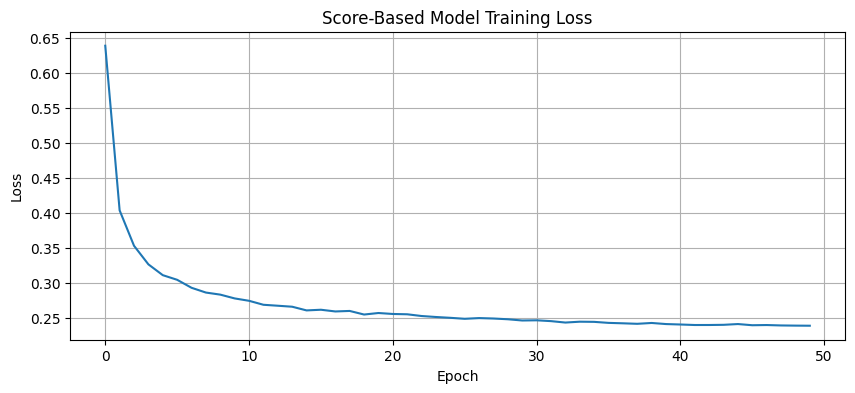


Final loss: 0.2390


In [13]:
print("Training score matching model on Fashion-MNIST...")
print(f"Total training samples: {len(train_subset)}")
print(f"Noise levels: {len(sigma_levels)}")
print(f"Sigma range: [{sigma_levels[0]:.4f}, {sigma_levels[-1]:.4f}]")

training_losses, ema_model = train_score_model_with_ema(
    score_model,
    train_loader,
    sigma_levels,
    n_epochs=50,
    lr=1e-3,
    ema_beta=0.995,
    verbose=True
)

plt.figure(figsize=(10, 4))
plt.plot(training_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Score-Based Model Training Loss')
plt.grid(True)
plt.show()

print(f"\nFinal loss: {training_losses[-1]:.4f}")

## Step 5: Test Denoising Capability

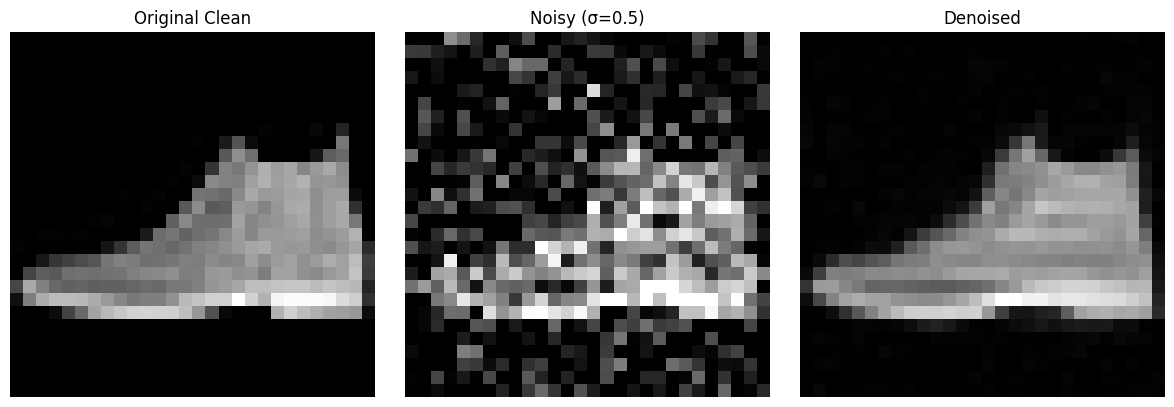

In [14]:
score_model.eval()
with torch.no_grad():
    real_img = next(iter(test_loader))[0][:1].to(device)
    
    sigma_test = 0.5
    noise = torch.randn_like(real_img) * sigma_test
    noisy_img = real_img + noise
    
    sigma_tensor = torch.ones(1, 1, device=device) * sigma_test
    predicted_score = score_model(noisy_img, sigma_tensor)
    
    denoised = noisy_img + 0.5 * sigma_test * predicted_score
    
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    axes[0].imshow((real_img[0, 0].cpu() + 1) / 2, cmap='gray')
    axes[0].set_title('Original Clean')
    axes[0].axis('off')
    
    axes[1].imshow(torch.clamp((noisy_img[0, 0].cpu() + 1) / 2, 0, 1), cmap='gray')
    axes[1].set_title(f'Noisy (σ={sigma_test})')
    axes[1].axis('off')
    
    axes[2].imshow(torch.clamp((denoised[0, 0].cpu() + 1) / 2, 0, 1), cmap='gray')
    axes[2].set_title('Denoised')
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()

## Step 6: Generate Samples with Multiple Methods

## Sampling Methods Comparison

### 1. Annealed Langevin Dynamics (ALD)

### 2. EDM (Elucidating Diffusion Models)

Generating samples with Annealed Langevin Dynamics (ALD)


ALD Sampling: 100%|██████████| 1/1 [02:45<00:00, 165.61s/it]


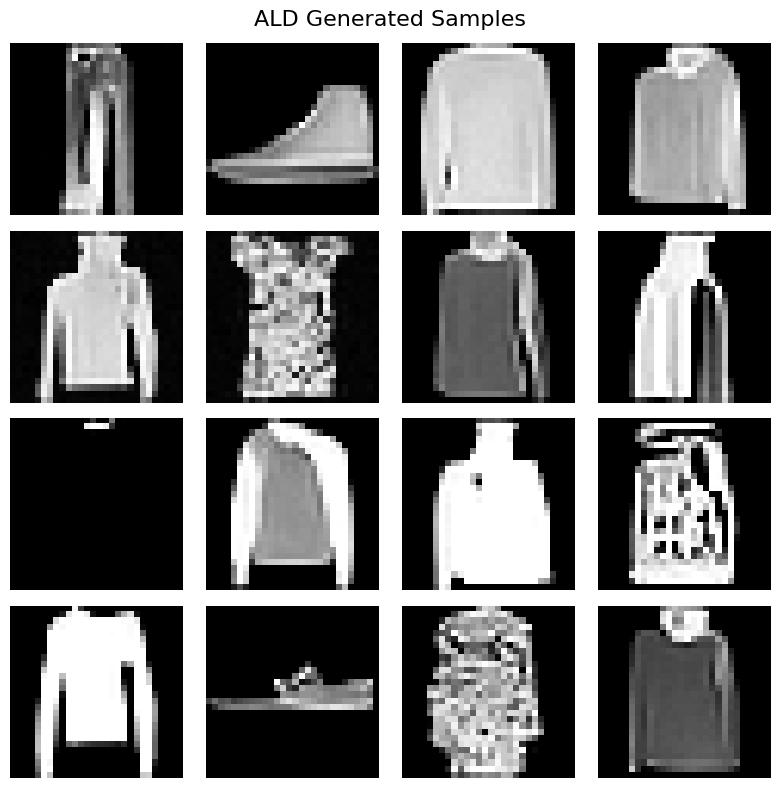


Generating samples with EDM (Karras + Heun)


EDM Sampling: 100%|██████████| 1/1 [00:01<00:00,  1.68s/it]


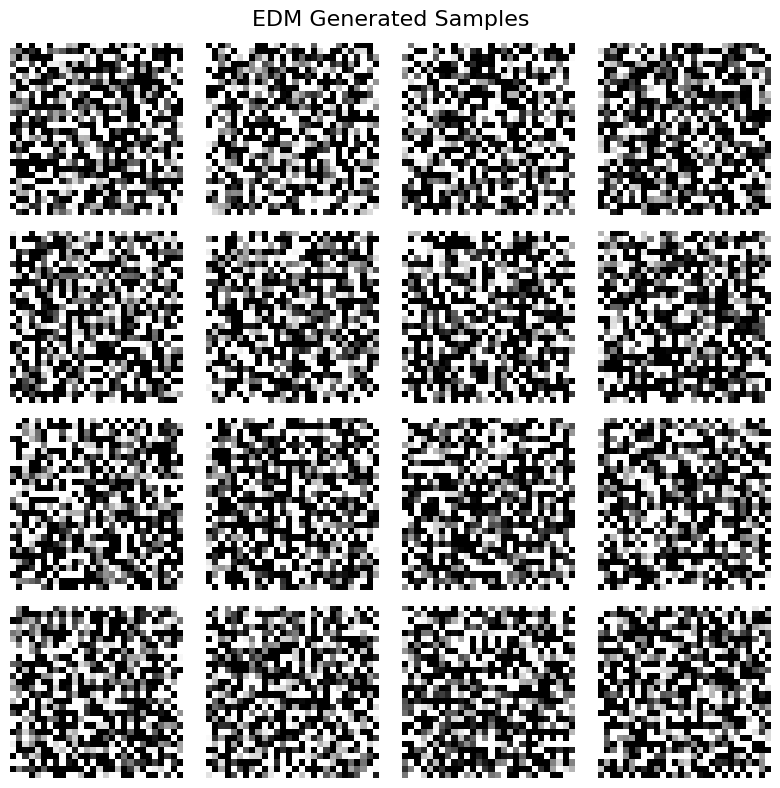

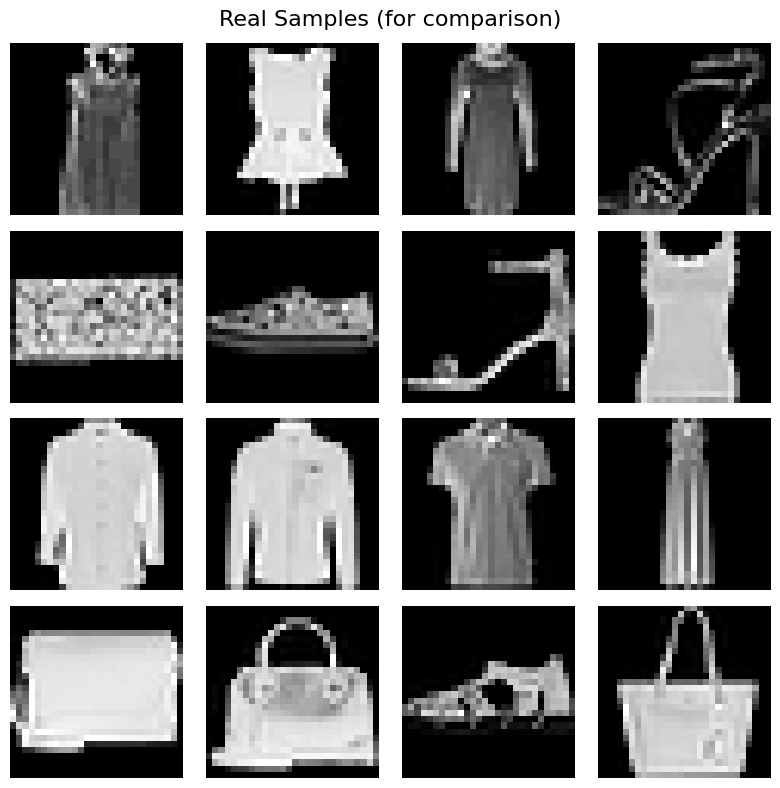

In [ ]:
print("="*60)
print("Generating samples with Annealed Langevin Dynamics (ALD)")
print("="*60)

samples_ald = generate_samples_ald(
    score_model,
    n_samples=16,
    sigma_levels=sigma_levels,
    n_steps_per_sigma=500,
    eps=0.05,
    batch_size=16,
    ema_model=ema_model
)

# Normalize to [0, 1]
samples_ald = (samples_ald + 1) / 2
samples_ald = torch.clamp(samples_ald, 0, 1)

fig, axes = plt.subplots(4, 4, figsize=(8, 8))
for i in range(16):
    axes[i // 4, i % 4].imshow(samples_ald[i, 0].numpy(), cmap='gray')
    axes[i // 4, i % 4].axis('off')
plt.suptitle('ALD Generated Samples', fontsize=16)
plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("Generating samples with EDM (Karras + Heun)")
print("="*60)

samples_edm = generate_samples_edm(
    score_model,
    n_samples=16,
    steps=100,
    sigma_min=0.01,
    sigma_max=1.0,
    rho=7.0,
    image_shape=(1, 28, 28),
    s_churn=0.0,  # Deterministic sampling
    batch_size=16,
    ema_model=ema_model
)

# Normalize to [0, 1]
samples_edm = (samples_edm + 1) / 2
samples_edm = torch.clamp(samples_edm, 0, 1)

fig, axes = plt.subplots(4, 4, figsize=(8, 8))
for i in range(16):
    axes[i // 4, i % 4].imshow(samples_edm[i, 0].numpy(), cmap='gray')
    axes[i // 4, i % 4].axis('off')
plt.suptitle('EDM Generated Samples', fontsize=16)
plt.tight_layout()
plt.show()

# Show real samples for comparison
fig, axes = plt.subplots(4, 4, figsize=(8, 8))
real_samples = next(iter(train_loader))[0][:16]
real_samples = (real_samples + 1) / 2
for i in range(16):
    axes[i // 4, i % 4].imshow(real_samples[i, 0].numpy(), cmap='gray')
    axes[i // 4, i % 4].axis('off')
plt.suptitle('Real Samples (for comparison)', fontsize=16)
plt.tight_layout()
plt.show()

## Step 7: Evaluation of Generated Samples

### I used ALD sampling for now since EDM sampler is not working


In [16]:
# Generate samples for evaluation using EDM (faster and higher quality)
# print("Generating 100 samples for evaluation using EDM sampler...")
# generated_samples = generate_samples_ald(
#     score_model,
#     n_samples=100,
#     steps=40,
#     sigma_min=0.01,
#     sigma_max=1.0,
#     rho=7.0,
#     image_shape=(1, 28, 28),
#     s_churn=0.0,
#     batch_size=16,
#     ema_model=ema_model
# )
generated_samples = generate_samples_ald(
    score_model,
    n_samples=100,
    sigma_levels=sigma_levels,
    n_steps_per_sigma=500,
    eps=0.05,
    batch_size=16,
    ema_model=ema_model
)

# Convert to numpy and normalize to [0, 1]
generated_samples = (generated_samples + 1) / 2
generated_samples = torch.clamp(generated_samples, 0, 1)
generated_samples = generated_samples.numpy()

print(f"Generated samples shape: {generated_samples.shape}")
print(f"Generated samples range: [{generated_samples.min():.3f}, {generated_samples.max():.3f}]")

ALD Sampling: 100%|██████████| 7/7 [08:59<00:00, 77.12s/it]

Generated samples shape: (100, 1, 28, 28)
Generated samples range: [0.000, 1.000]


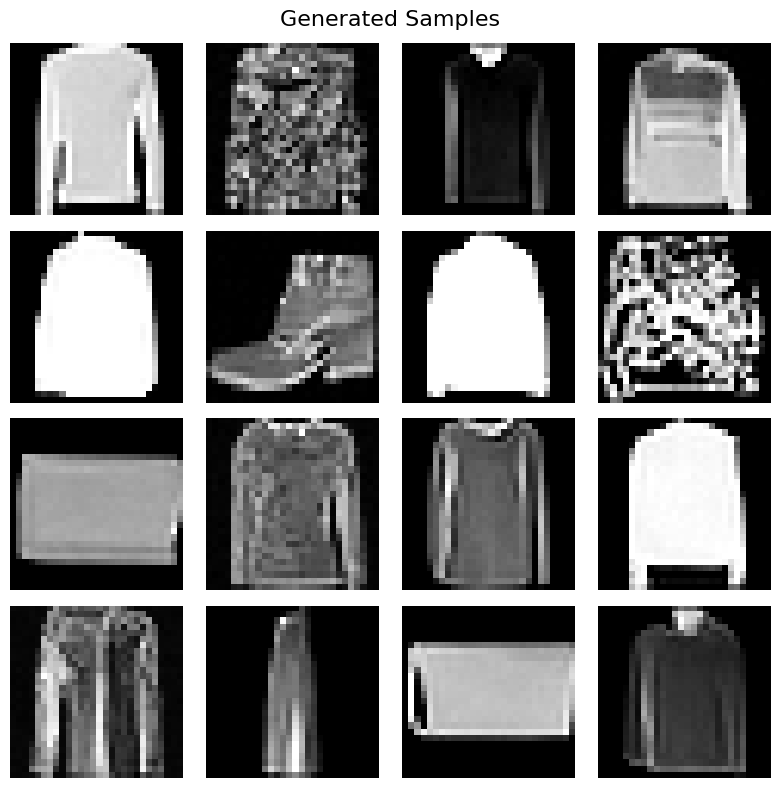

In [17]:
fig, axes = plt.subplots(4, 4, figsize=(8, 8))
for i in range(16):
    axes[i // 4, i % 4].imshow(generated_samples[i, 0], cmap='gray')
    axes[i // 4, i % 4].axis('off')
plt.suptitle('Generated Samples', fontsize=16)
plt.tight_layout()
plt.show()

## Quantitative evaluation(use FID score for images)

In [18]:
# FID evaluation using pytorch-fid (in-memory, no saving)
# Reference: https://github.com/mseitzer/pytorch-fid
import sys
import subprocess
import numpy as np
import torch
import torch.nn.functional as F

# Ensure pytorch-fid is installed
try:
    import pytorch_fid
except Exception:
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q', 'pytorch-fid'])
    import pytorch_fid

from pytorch_fid.inception import InceptionV3
from pytorch_fid.fid_score import calculate_frechet_distance

# Require existing generated_samples (numpy, [N,1,28,28] in [0,1])
if 'generated_samples' not in globals() or not isinstance(generated_samples, np.ndarray):
    raise RuntimeError("generated_samples not found. Please run the generation cell first.")

num_fid_samples = min(1000, generated_samples.shape[0])

# Prepare generated tensor [N,3,299,299] in [0,1]
gen = torch.from_numpy(generated_samples[:num_fid_samples]).float().to(device)
if gen.shape[1] == 1:
    gen = gen.repeat(1, 3, 1, 1)
gen = F.interpolate(gen, size=(299, 299), mode='bilinear', align_corners=False)

# Collect real images from test_loader, map to [0,1], 3ch, 299
real_batches = []
total = 0
for batch_x, _ in test_loader:
    x = torch.clamp((batch_x.to(device) + 1) / 2, 0, 1)  # [-1,1] -> [0,1]
    if x.shape[1] == 1:
        x = x.repeat(1, 3, 1, 1)
    x = F.interpolate(x, size=(299, 299), mode='bilinear', align_corners=False)
    real_batches.append(x)
    total += x.shape[0]
    if total >= num_fid_samples:
        break
real = torch.cat(real_batches, dim=0)[:num_fid_samples]

# Select feature dimensionality based on sample size to avoid singular covariances
if num_fid_samples >= 2048:
    dims = 2048
elif num_fid_samples >= 768:
    dims = 768
elif num_fid_samples >= 192:
    dims = 192
else:
    dims = 64

# Build InceptionV3 at the chosen layer
dim_to_block = InceptionV3.BLOCK_INDEX_BY_DIM
block_idx = dim_to_block[dims]
inception = InceptionV3([block_idx]).to(device)
inception.eval()

@torch.no_grad()
def get_acts(x: torch.Tensor, bs: int = 64) -> np.ndarray:
    acts = []
    for i in range(0, x.shape[0], bs):
        out = inception(x[i:i+bs])[0]
        # Global average pool spatial dims if present (per pytorch-fid behavior for dims!=2048)
        if out.ndim == 4 and (out.shape[2] > 1 or out.shape[3] > 1):
            out = out.mean(dim=(2, 3))
        else:
            out = out.view(out.size(0), -1)
        acts.append(out.cpu().numpy())
    return np.concatenate(acts, axis=0).astype(np.float64)

real_acts = get_acts(real)
gen_acts = get_acts(gen)

mu_r, sigma_r = real_acts.mean(0), np.cov(real_acts, rowvar=False)
mu_g, sigma_g = gen_acts.mean(0), np.cov(gen_acts, rowvar=False)

fid_value = calculate_frechet_distance(mu_r, sigma_r, mu_g, sigma_g)
print(f"FID (pytorch-fid, in-memory, dims={dims}) real vs generated: {fid_value:.2f}")

FID (pytorch-fid, in-memory, dims=64) real vs generated: 0.62


## vanilla VAE for benchmark

VAE epoch 1/50 - loss: 346.4517
VAE epoch 2/50 - loss: 267.4193
VAE epoch 3/50 - loss: 255.5074
VAE epoch 4/50 - loss: 250.4521
VAE epoch 5/50 - loss: 247.8859
VAE epoch 6/50 - loss: 246.1332
VAE epoch 7/50 - loss: 244.7935
VAE epoch 8/50 - loss: 243.9818
VAE epoch 9/50 - loss: 243.2412
VAE epoch 10/50 - loss: 242.5137
VAE epoch 11/50 - loss: 242.1036
VAE epoch 12/50 - loss: 241.5959
VAE epoch 13/50 - loss: 241.2853
VAE epoch 14/50 - loss: 240.8390
VAE epoch 15/50 - loss: 240.6094
VAE epoch 16/50 - loss: 240.3839
VAE epoch 17/50 - loss: 240.0305
VAE epoch 18/50 - loss: 239.7315
VAE epoch 19/50 - loss: 239.4367
VAE epoch 20/50 - loss: 239.3886
VAE epoch 21/50 - loss: 239.1434
VAE epoch 22/50 - loss: 238.9997
VAE epoch 23/50 - loss: 238.8519
VAE epoch 24/50 - loss: 238.5434
VAE epoch 25/50 - loss: 238.4532
VAE epoch 26/50 - loss: 238.3648
VAE epoch 27/50 - loss: 238.1978
VAE epoch 28/50 - loss: 237.9814
VAE epoch 29/50 - loss: 237.8703
VAE epoch 30/50 - loss: 237.8782
VAE epoch 31/50 - l

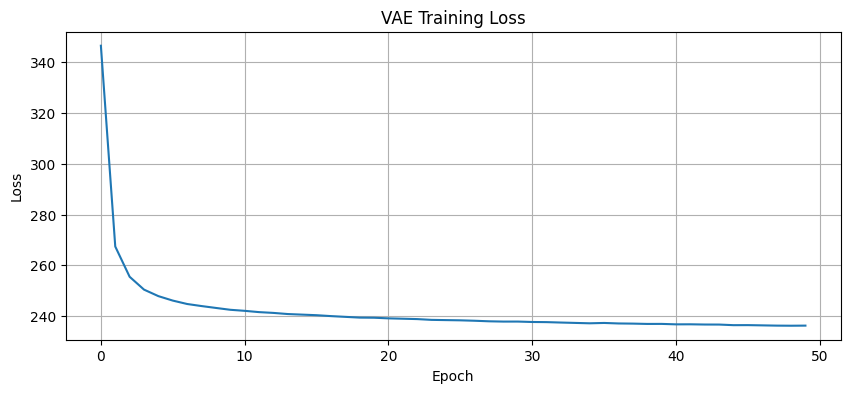

In [19]:
# ------------------------------
# Vanilla VAE benchmark on Fashion-MNIST + FID
# ------------------------------
import torch.nn as nn
import torch.optim as optim

class VanillaVAE(nn.Module):
    def __init__(self, latent_dim: int = 32):
        super().__init__()
        # Encoder: 1x28x28 -> convs -> flatten
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 4, stride=2, padding=1),  # 14x14
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, 4, stride=2, padding=1), # 7x7
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, 3, stride=1, padding=1), # 7x7
            nn.ReLU(inplace=True)
        )
        self.enc_out_dim = 128 * 7 * 7
        self.fc_mu = nn.Linear(self.enc_out_dim, latent_dim)
        self.fc_logvar = nn.Linear(self.enc_out_dim, latent_dim)
        
        # Decoder: latent -> deconv to 1x28x28
        self.fc_dec = nn.Linear(latent_dim, self.enc_out_dim)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1), # 14x14
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),  # 28x28
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 1, 3, stride=1, padding=1),
            nn.Sigmoid()
        )
    
    def encode(self, x):
        h = self.encoder(x)
        h = h.view(h.size(0), -1)
        return self.fc_mu(h), self.fc_logvar(h)
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        h = self.fc_dec(z)
        h = h.view(h.size(0), 128, 7, 7)
        return self.decoder(h)
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar

@torch.no_grad()
def sample_vae(model: nn.Module, n: int, latent_dim: int) -> torch.Tensor:
    model.eval()
    z = torch.randn(n, latent_dim, device=device)
    x = model.decode(z)
    return x.clamp(0, 1)

# Train VAE quickly
latent_dim = 32
vae = VanillaVAE(latent_dim=latent_dim).to(device)
optimizer = optim.Adam(vae.parameters(), lr=1e-3)

num_epochs = 50
vae_epoch_losses = []
vae.train()
for epoch in range(num_epochs):
    total_loss = 0.0
    total_elbo = 0.0
    num_samples_seen = 0
    for x, _ in train_loader:
        # Map to [0,1] for BCE
        x = torch.clamp((x.to(device) + 1) / 2, 0, 1)
        optimizer.zero_grad()
        recon, mu, logvar = vae(x)
        # Reconstruction + KL
        recon_loss = nn.functional.binary_cross_entropy(recon, x, reduction='sum')
        kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        loss = (recon_loss + kld) / x.size(0)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * x.size(0)
        num_samples_seen += x.size(0)
    avg_epoch_loss = total_loss / num_samples_seen
    vae_epoch_losses.append(avg_epoch_loss)
    print(f"VAE epoch {epoch+1}/{num_epochs} - loss: {avg_epoch_loss:.4f}")

# Plot VAE training loss
plt.figure(figsize=(10, 4))
plt.plot(vae_epoch_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('VAE Training Loss')
plt.grid(True)
plt.show()

In [20]:
# Generate samples from VAE
num_fid_samples = min(100, len(test_dataset))
with torch.no_grad():
    vae_gen = sample_vae(vae, num_fid_samples, latent_dim)

# Prepare VAE generated for FID (repeat to 3ch, resize)
if vae_gen.shape[1] == 1:
    vae_gen_rgb = vae_gen.repeat(1, 3, 1, 1)
else:
    vae_gen_rgb = vae_gen
vae_gen_rgb = F.interpolate(vae_gen_rgb, size=(299, 299), mode='bilinear', align_corners=False)

# Compute acts and FID for VAE using the same pipeline
vae_gen_acts = get_acts(vae_gen_rgb)
mu_g_vae, sigma_g_vae = vae_gen_acts.mean(0), np.cov(vae_gen_acts, rowvar=False)
fid_value_vae = calculate_frechet_distance(mu_r, sigma_r, mu_g_vae, sigma_g_vae)
print(f"FID (pytorch-fid, in-memory, dims={dims}) VAE vs real: {fid_value_vae:.2f}")

FID (pytorch-fid, in-memory, dims=64) VAE vs real: 0.53


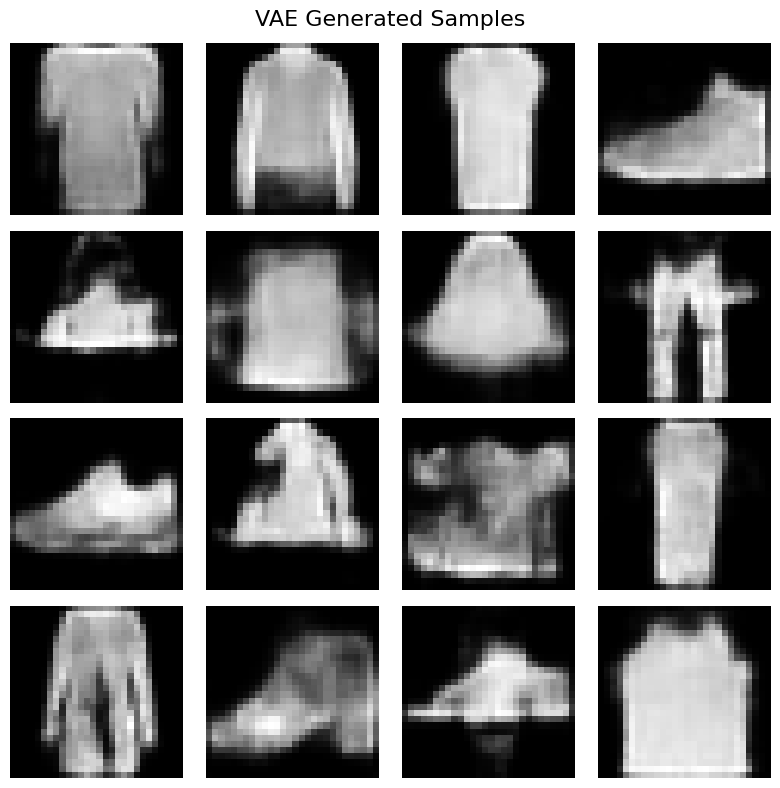

In [21]:
# Convert generated images to numpy and normalize to [0, 1]
vae_gen_np = vae_gen.cpu().numpy()
vae_gen_np = (vae_gen_np + 1) / 2
vae_gen_np = np.clip(vae_gen_np, 0, 1)

fig, axes = plt.subplots(4, 4, figsize=(8, 8))
for i in range(16):
    axes[i // 4, i % 4].imshow(vae_gen_np[i, 0], cmap='gray')
    axes[i // 4, i % 4].axis('off')
plt.suptitle('VAE Generated Samples', fontsize=16)
plt.tight_layout()
plt.show()